## Table of Contents

<a id='table_of_contents'></a>

1. [Import libraries](#imports)
2. [Import data](#import_data)
3. [Sampling Data](#sampling)
3. [Text Preprocessing & cleaning](#preprocessing)<br>
4. [Result Evaluation & Conclusion](#res)<br>

# 1. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [1]:
import numpy as np
import pandas as pd
import spacy
import contractions
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.utils import resample
from wordcloud import WordCloud

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')
tqdm.pandas()

nlp = spacy.load('en_core_web_sm')   

# 2. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [4]:
con =  sqlite3.connect('database.sqlite')
con

In [5]:
querry = """ select * from Reviews where Score!=3 limit 50000"""
data = pd.read_sql_query(querry, con)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data.Score.value_counts()

Score
5    34007
4     7781
1     5179
2     3033
Name: count, dtype: int64

In [7]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [8]:
data = data[data.HelpfulnessNumerator <= data.HelpfulnessDenominator]

In [9]:
data.shape

(49999, 10)

In [10]:
df_review = data[['Text', 'Score']].dropna()

In [11]:
df_review.shape

(49999, 2)

In [12]:
df_review.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [13]:
def threshold(x):
    """ 
    defining threshold for the review scores 
    above 3 considered good
    below 3 considered bad """
    if x > 3:
        return 1
    return 0

In [14]:
df_review['Score'] = df_review['Score'].apply(threshold)

In [15]:
df_review.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [16]:
df_review['Text'][6]

"This saltwater taffy had great flavors and was very soft and chewy.  Each candy was individually wrapped well.  None of the candies were stuck together, which did happen in the expensive version, Fralinger's.  Would highly recommend this candy!  I served it at a beach-themed party and everyone loved it!"

In [17]:
df_review.Score.value_counts()

Score
1    41787
0     8212
Name: count, dtype: int64

# 3. Sampling Data and cleaning <a id='sampling'></a>
[Back to top](#table_of_contents)

###  Resampling the data to overcome class imbalance
###  considering undersampling of the majority class so that it matches the minority class

In [18]:
df_class_1 = df_review[df_review['Score']==1]
df_class_0 = df_review[df_review['Score']==0]

#undersampling the majority class
df_resample = resample(df_class_1, replace=False, n_samples=len(df_class_0), random_state=42)
df_food_review = pd.concat([df_resample, df_class_0])
df_food_review = df_food_review.sample(frac=1, random_state=42).reset_index(drop=True) # shuffling the data

In [19]:
df_food_review.Score.value_counts()

Score
0    8212
1    8212
Name: count, dtype: int64

In [20]:
df_food_review.shape

(16424, 2)

In [21]:
df_food_review['Text'][332]

'My order arrived on time.  I bought this for friends at work.  It was good, as far as taste, but this time the licorice was a bit harder than usual.  What always got me about Lucky Country Licorice was the soft texture, but this time I was disappointed that it seemed a bit hard.'

In [22]:
df_food_review['Text'][32]

'I love <a href="http://www.amazon.com/gp/product/B000EVLS2E">Arrowhead Mills Puffed Corn Cereal, 6-Ounce Bags (Pack of 12)</a>.  It is whole grain and easy to eat with or without liquid.  My favorite is to munch on it as I am watching a good movie instead of popcorn.  You don\'t need to add butter or any type of fat or fat substitute.  It tastes great just the way it is.<br /><br />For those with wheat allergies or on a gluten free diet, this is a great option either for a meal or a snack.  Purchasing through Amazon seems to be the least expensive way I have found.'

### now we have a balanced dataset

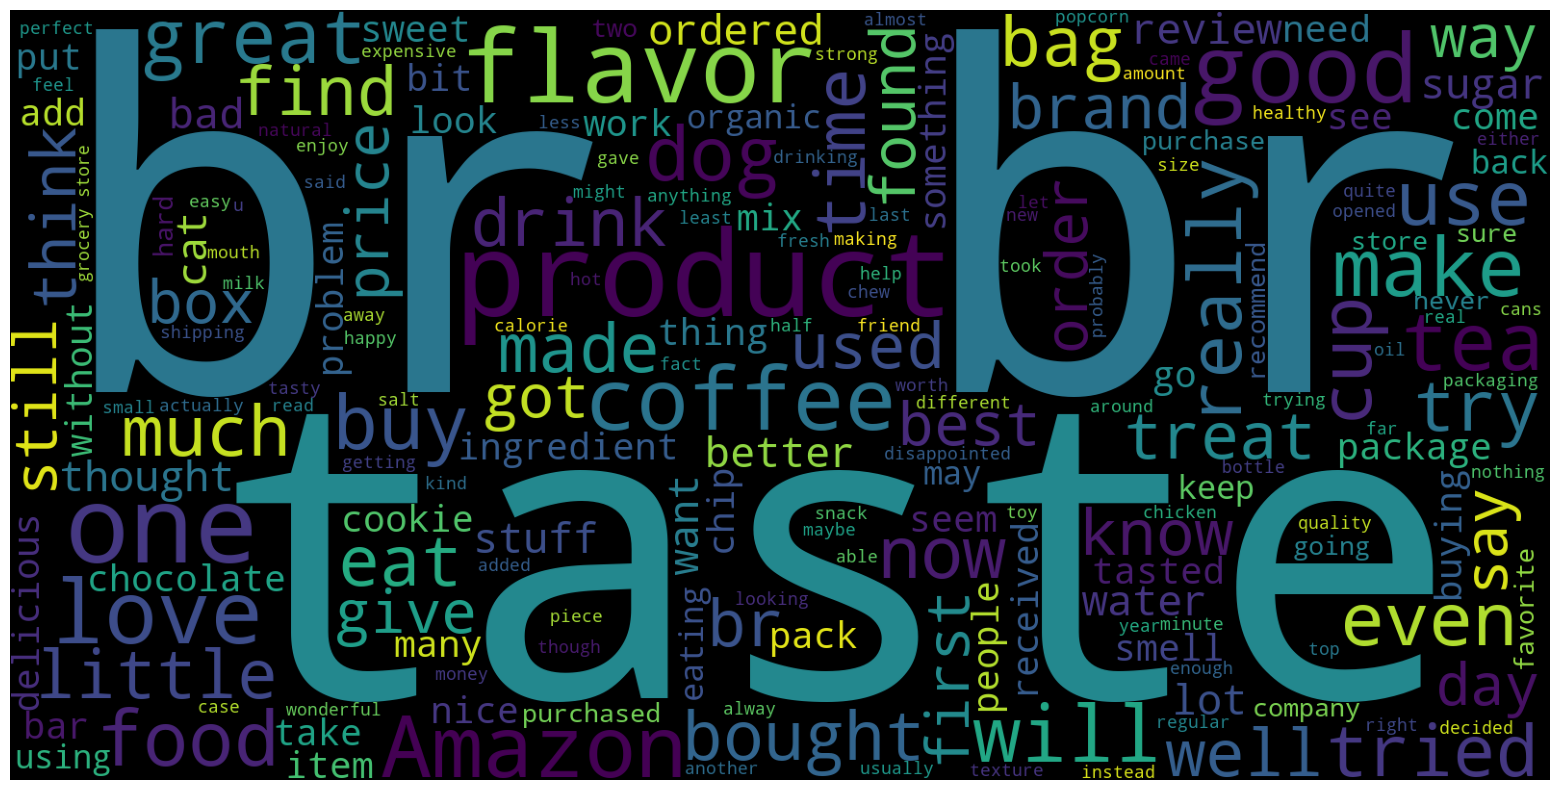

In [23]:
wc = WordCloud(width=1600, height=800).generate(' '.join(df_food_review['Text']))
plt.figure(1, figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

# 4. Text Preprocessing and cleaning <a id='preprocessing'></a>
[Back to top](#table_of_contents)

In [24]:
def clean_reviews(raw_text):
    """
    Cleans raw review text by removing HTML tags, converting to lowercase, 
    expanding contractions, removing URLs, keeping only alphabetic characters, 
    and lemmatizing tokens. Returns the cleaned and lemmatized text.
    Args:
        raw_text (str): The raw text of the review.
    Returns:
        str: The cleaned and lemmatized text.
    """
    text = BeautifulSoup(raw_text, 'html.parser').get_text()
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    doc = nlp(text)
    clean_tokens = [token.lemma_ for token in doc]
    return ' '.join(clean_tokens)     

In [25]:
df_food_review['clean_text'] = df_food_review['Text'].progress_apply(clean_reviews)

100%|██████████| 16424/16424 [05:11<00:00, 52.80it/s]


In [26]:
df_food_review['Text'][1]

"My cat usually loves Fancy Feast wet food and finishes it in a matter of hours but this one sits there for almost a whole day before it's totally gone.  It seems drier than other Fancy Feast varieties.  I have usually given him the assorted Seafood pack which is now unavailable via Subscribe and Save.  He also loves the grilled ones but they don't seem to have enough actual food, lots of gravy."

In [27]:
df_food_review['clean_text'][1]

'my cat usually love fancy feast wet food and finish it in a matter of hour but this one sit there for almost a whole day before it be totally go   it seem dry than other fancy feast variety   I have usually give he the assorted seafood pack which be now unavailable via subscribe and save   he also love the grill one but they do not seem to have enough actual food lot of gravy'

In [28]:
df_food_review['Text'][32]

'I love <a href="http://www.amazon.com/gp/product/B000EVLS2E">Arrowhead Mills Puffed Corn Cereal, 6-Ounce Bags (Pack of 12)</a>.  It is whole grain and easy to eat with or without liquid.  My favorite is to munch on it as I am watching a good movie instead of popcorn.  You don\'t need to add butter or any type of fat or fat substitute.  It tastes great just the way it is.<br /><br />For those with wheat allergies or on a gluten free diet, this is a great option either for a meal or a snack.  Purchasing through Amazon seems to be the least expensive way I have found.'

In [30]:
df_food_review['clean_text'][32]

'I love arrowhead mill puff corn cereal ounce bag pack of    it be whole grain and easy to eat with or without liquid   my favorite be to munch on it as I be watch a good movie instead of popcorn   you do not need to add butter or any type of fat or fat substitute   it taste great just the way it isfor those with wheat allergy or on a gluten free diet this be a great option either for a meal or a snack   purchasing through amazon seem to be the least expensive way I have find'

### cleaned text wordcloud

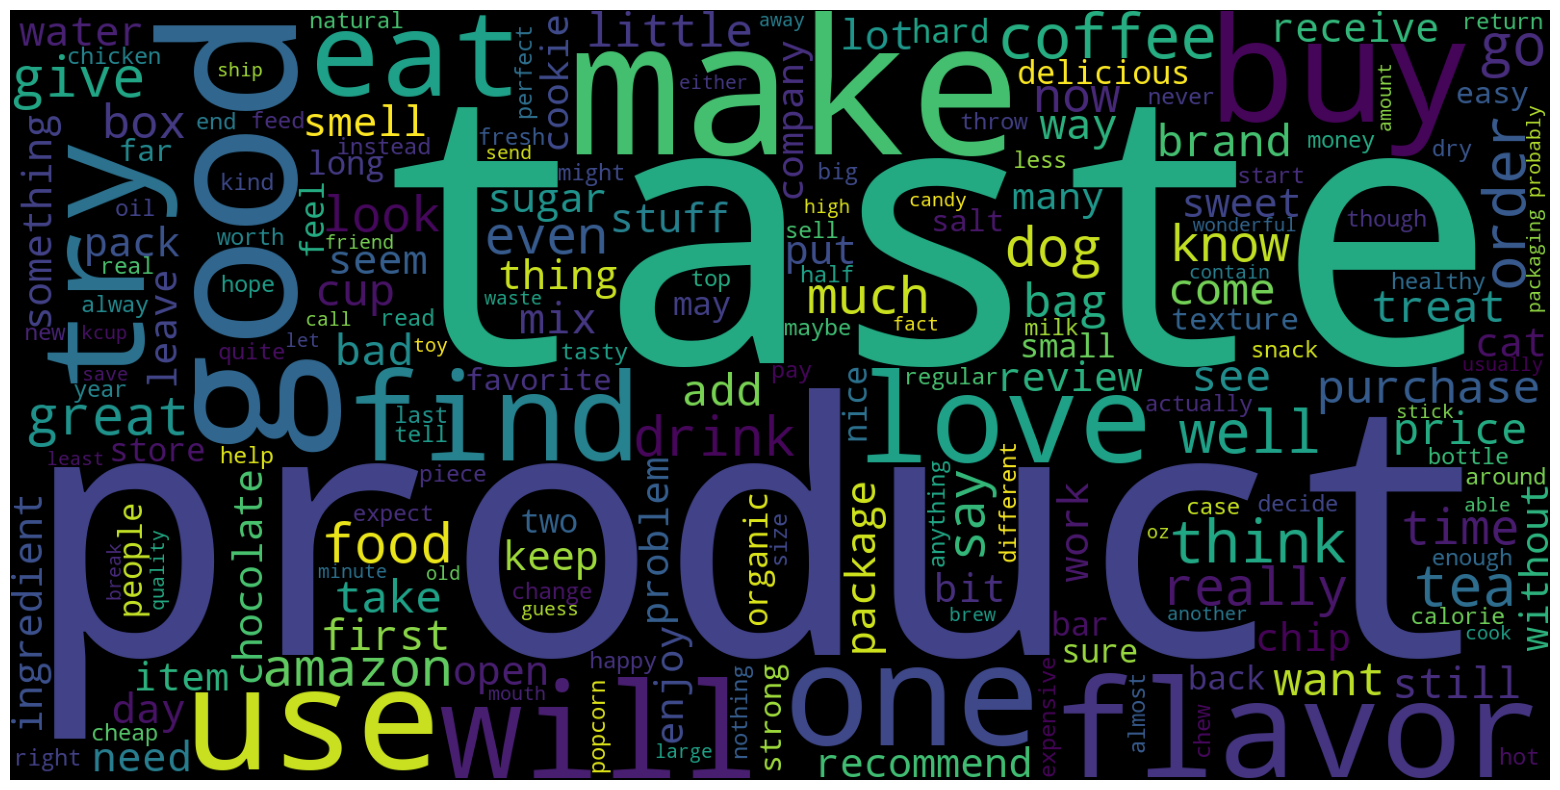

In [31]:
wc_clean = WordCloud(width=1600, height=800).generate(' '.join(df_food_review['clean_text']))
plt.figure(1, figsize=(20, 10))
plt.imshow(wc_clean)
plt.axis('off')
plt.show()

In [32]:
# saving the cleaned data to pickle file
import pickle
file_name = 'preprocessed_food_reviews.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(df_food_review, file)
print(f"DataFrame saved to {file_name}")

DataFrame saved to preprocessed_food_reviews.pkl
